In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
import os
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
def lr_schedule(epoch):
    initial_lr = 0.001  
    drop = 0.5  
    epochs_drop = 10  
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return max(lr,0.0001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #horizontal_flip=True,
    #vertical_flip=True,
    rescale=1./255.0)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [5]:
main_path = os.getcwd() + '/covid_data'

train_dataset = train_datagen.flow_from_directory(
    directory= main_path + '/train/',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=None)

val_dataset = val_datagen.flow_from_directory(
    directory = main_path + '/validation',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=150,
    class_mode="categorical",
    shuffle=False,
    seed=None)

test_dataset = test_datagen.flow_from_directory(
    directory = main_path + '/test',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=150,
    class_mode="categorical",
    shuffle=False,
    seed=None)

Found 14811 images belonging to 4 classes.
Found 2119 images belonging to 4 classes.
Found 4235 images belonging to 4 classes.


In [6]:
for image_batch, labels_batch in train_dataset:
  print('Image Shape: {}'.format(image_batch.shape))
  print('Label Shape: {}'.format(labels_batch.shape))
  break

Image Shape: (32, 224, 224, 3)
Label Shape: (32, 4)


In [6]:
# Load pre-trained ResNet50 model with pre-trained weights and without top layers
base_model = InceptionV3(weights='imagenet', include_top=False)

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation = 'relu')(x)
x = Dense(1024,activation = 'relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['categorical_accuracy'])

In [7]:
history = model.fit(train_dataset, validation_data=val_dataset,  epochs=75,callbacks=[LearningRateScheduler(lr_schedule),early_stopping])

Epoch 1/75
463/463 [==============================] - 93s 189ms/step - loss: 0.6384 - categorical_accuracy: 0.7557 - val_loss: 0.4649 - val_categorical_accuracy: 0.8244
Epoch 2/75
463/463 [==============================] - 85s 184ms/step - loss: 0.4911 - categorical_accuracy: 0.8091 - val_loss: 0.4498 - val_categorical_accuracy: 0.8320
Epoch 3/75
463/463 [==============================] - 87s 189ms/step - loss: 0.4405 - categorical_accuracy: 0.8306 - val_loss: 0.4879 - val_categorical_accuracy: 0.7999
Epoch 4/75
463/463 [==============================] - 89s 192ms/step - loss: 0.4163 - categorical_accuracy: 0.8407 - val_loss: 0.4485 - val_categorical_accuracy: 0.8282
Epoch 5/75
463/463 [==============================] - 89s 192ms/step - loss: 0.3946 - categorical_accuracy: 0.8512 - val_loss: 0.4548 - val_categorical_accuracy: 0.8160
Epoch 6/75
463/463 [==============================] - 91s 196ms/step - loss: 0.3797 - categorical_accuracy: 0.8565 - val_loss: 0.4057 - val_categorical_acc

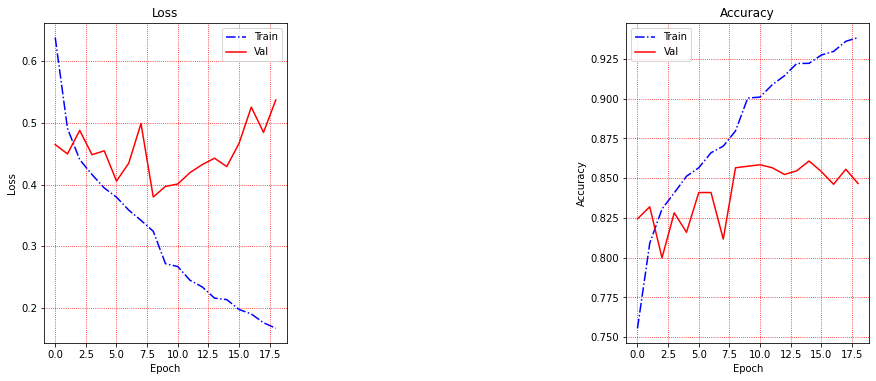

In [8]:
plt.figure(figsize = (20, 20))
plt.subplot(341)
plt.plot(history.history['loss'], color='blue', linestyle = 'dashdot', label='Train')
plt.plot(history.history['val_loss'], color='red', linestyle="solid", label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(visible = True, which = 'both', color= 'r', linestyle = 'dotted')
plt.legend()

plt.subplot(343)
plt.plot(history.history['categorical_accuracy'], color='blue', linestyle = 'dashdot', label='Train')
plt.plot(history.history['val_categorical_accuracy'], color='red', linestyle="solid", label='Val')
# plt.xticks(np.arange(0, 31, step=2))  # Set label locations.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(visible = True, which = 'both', color= 'r', linestyle = 'dotted')
plt.legend()

29/29 [==============================] - 24s 843ms/step - loss: 0.4109 - categorical_accuracy: 0.8475
Test Loss: 0.410858690738678
Test Accuracy: 0.8474616408348083


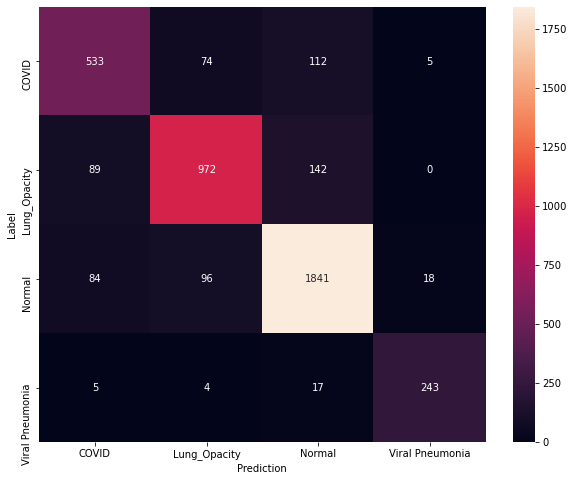

In [9]:
test_result = model.evaluate(test_dataset, batch_size = 128)

print('Test Loss: {}'.format(test_result[0]))
print('Test Accuracy: {}'.format(test_result[1]))

class_names = list(train_dataset.class_indices)

label_names = class_names
y_pred = model.predict(test_dataset, batch_size=128)
y_test = test_dataset.labels
cm = tf.math.confusion_matrix(y_test, 
                              y_pred.argmax(axis=1),
                              num_classes = 4)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, 
              annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('CM.png', dpi = 300)
plt.show()